# SYDE 556/750 --- Assignment 3
**Student ID: 20854840**

*Note:* Please include your numerical student ID only, do *not* include your name.

*Note:* Refer to the [PDF](https://github.com/celiasmith/syde556-f22/raw/master/assignments/assignment_03/syde556_assignment_03.pdf) for the full instructions (including some hints), this notebook contains abbreviated instructions only. Cells you need to fill out are marked with a "writing hand" symbol. Of course, you can add new cells in between the instructions, but please leave the instructions intact to facilitate marking.

In [1]:
# Import numpy and matplotlib -- you shouldn't need any other libraries
import numpy as np
from numpy import fft
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import scipy
from scipy.integrate import quad
from uuid import uuid4

# Change Seed whenever needed to get reproducible results
seed  = 208548018

# Fix the numpy random seed for reproducible results
np.random.seed(seed)

# Some formating options
%config InlineBackend.figure_formats = ['svg']

In [2]:
def calc_rmse(x, y):
    '''Calculate root mean squared error of two signals'''
    return np.sqrt(np.mean(np.power(x - y,2)))
     

def randComplex():
    return np.random.normal() + np.random.normal() * 1j

#If symmetry exists, it returns a boolean indicating its existence and the index where the symmetric element is located.
def symmetryExists(f, F):
    neg = -f
    return neg in F and f != 0, np.where(F == neg)

# Calculate signal RMS
def signalRMS(signal):
    return np.sqrt(np.mean(np.power(signal, 2)))

# Calculates the current RMS of the signal and then scales all elements to achieve the desired RMS.
def rescaleSignal(signal, idealRMS):
    currentRMS = signalRMS(signal)
    rescaledSignal = [p * idealRMS / currentRMS for p in signal]
    return rescaledSignal

def locations(index):
    return int(index[0])


# It's a way to ensure that the frequency domain and signal values remain aligned.
def tuplify(F, Z):
    return (list(tt) for tt in zip(*sorted(zip(F, Z))))

def calcRmse(x1, x2):
    return np.sqrt(np.mean(np.power(x1 - x2, 2)))

def generate_signal(T, dt, rms, limit, seed):

    if seed != 0:
        np.random.seed(int(seed))
    # generate a times scale
    timescale = np.arange(0, T, dt)
    # get the number of points so that we can create a signal in the frequency domain
    num_pts = len(timescale)
    # convert to frequency domain
    F = fft.fftfreq(num_pts, dt)
    # create a frequenct signal of zeros
    length_F = len(F)
    # create zeros for the frequency domain
    zeros = np.zeros(length_F)
    Z = zeros.tolist()

    for idx, f in enumerate(F):
        if Z[idx] == 0:
            magnitude_f = abs(f)
            if magnitude_f <= limit:
                im = randComplex()
                Z[idx] = im
                # ensure that we account for the negative symmetric value
                exists, index = symmetryExists(f, F)
                if exists:
                    location = locations(index)
                    # assig it to the complex conjugate
                    Z[location] = np.conj(im)
        else:
            continue
    # perform inverse fft
    z = fft.ifft(Z)
    # select the real components
    z = z.real
    # rescale based on the current and ideal rmse
    z = rescaleSignal(z, rms)

    # convert back to frequency domain
    Z = fft.fft(z)
    # touple Z so that it aligns with our intial number of samples
    F, Z = tuplify(F, Z)
    return z, Z


# 1. Decoding from a population

**a) Tuning curves.** Plot the tuning curves (firing rate of each neuron for different $x$ values between $-2$ and $2$).

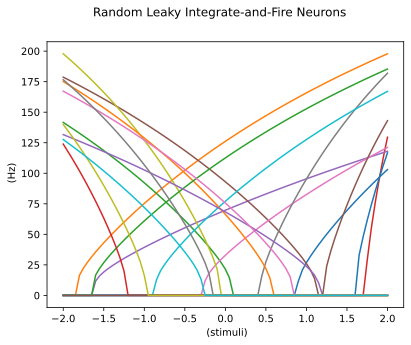

In [3]:
class LIFNeuron:
    e_vals = [-1,1]

    def __init__(self, tau_ref=0.002, tau_rc=0.02):
        self.x_int = np.random.uniform(-2,2)
        self.max_fire_rate = np.random.uniform(100,200)
        self.encoder = np.random.choice(self.e_vals)
        self.tau_ref = tau_ref
        self.tau_rc = tau_rc
        
        J_max = 1/(1 - np.exp((tau_ref - 1/self.max_fire_rate)/tau_rc))
        self.alpha = (J_max - 1)/(2 - self.encoder*self.x_int)
        self.j_bias = 1 - self.alpha*self.encoder*self.x_int

    def set_vars(self, enc, alpha, j_bias):
        self.encoder = enc
        self.alpha = alpha
        self.j_bias = j_bias
    
    def print_vars(self):
        print(self.__dict__)

    def rates(self, x):
        rates = []
        for pos in x:
            rate = 0
            J = self.alpha*pos*self.encoder+self.j_bias
            if J > 1:
                rate = 1/(self.tau_ref - self.tau_rc*np.log(1 - 1/J))
            rates.append(rate)
        return rates
    
    def spikes(self, x, dt):
        
        num_ref_steps = np.floor(self.tau_ref/dt)
        ref_count = 0
        spike_count = 0
        voltages = []
        spikes = []
        v = 0
        v_next = 0
        for stim in x:
            J = self.alpha*stim*self.encoder + self.j_bias
            if ref_count > 0:
                v = 0
                ref_count -= 1
            elif v >= 1: #spike
                v = 1 #constant spike voltage
                ref_count = num_ref_steps
                spike_count +=1
            elif v < 0: #keep positive
                v = 0
            
            if v == 1:
                spikes.append(1)
            else:
                spikes.append(0)
                
            v_next = v + dt*(1/self.tau_rc)*(J - v)
            voltages.append(v)
            v = v_next
        
        return voltages, spike_count, spikes
    
class LIFNeuronR1:
    e_vals = [-1,1]

    def __init__(self, tau_ref=0.002, tau_rc=0.02):
        self.x_int = np.random.uniform(-2,2)
        self.max_fire_rate = np.random.uniform(100,200)
        self.encoder = np.random.choice(self.e_vals)
        self.tau_ref = tau_ref
        self.tau_rc = tau_rc
        
        J_max = 1/(1 - np.exp((tau_ref - 1/self.max_fire_rate)/tau_rc))
        self.alpha = (J_max - 1)/(1 - self.encoder*self.x_int)
        self.j_bias = 1 - self.alpha*self.encoder*self.x_int

    def set_vars(self, enc, alpha, j_bias):
        self.encoder = enc
        self.alpha = alpha
        self.j_bias = j_bias
    
    def print_vars(self):
        print(self.__dict__)

    def rates(self, x):
        rates = []
        for pos in x:
            rate = 0
            J = self.alpha*pos*self.encoder+self.j_bias
            if J > 1:
                rate = 1/(self.tau_ref - self.tau_rc*np.log(1 - 1/J))
            rates.append(rate)
        return rates
    
    def spikes(self, x, dt):
        
        num_ref_steps = np.floor(self.tau_ref/dt)
        ref_count = 0
        spike_count = 0
        voltages = []
        spikes = []
        v = 0
        v_next = 0
        for stim in x:
            J = self.alpha*stim*self.encoder + self.j_bias
            if ref_count > 0:
                v = 0
                ref_count -= 1
            elif v >= 1: #spike
                v = 1 #constant spike voltage
                ref_count = num_ref_steps
                spike_count +=1
            elif v < 0: #keep positive
                v = 0
            
            if v == 1:
                spikes.append(1)
            else:
                spikes.append(0)
                
            v_next = v + dt*(1/self.tau_rc)*(J - v)
            voltages.append(v)
            v = v_next
        
        return voltages, spike_count, spikes

def generate_LIF_neurons(num, stimuli):
    neurons = []
    rates = []
    for i in range(num):
        n = LIFNeuron()
        neurons.append(n)
        rates.append(n.rates(stimuli))
    return neurons, rates

plt.figure()
plt.suptitle('Random Leaky Integrate-and-Fire Neurons')

num_neurons = 20
S = 81 # samples
x = np.linspace(-2,2,S)
neurons, rates = generate_LIF_neurons(num_neurons, x)
for neuron, nrate in zip(neurons, rates):
    plt.plot(x, nrate)

plt.xlabel(' (stimuli)')
plt.ylabel(' (Hz)')
plt.show()

**b) Decoder and error computation.** Compute the decoders and plot $(x-\hat{x})$. When computing decoders, take into account noise ($\sigma=0.1 \cdot 200\,\mathrm{Hz}$). When computing $\hat{x}$, add random Gaussian noise with $\sigma=0.1 \cdot 200\,\mathrm{Hz}$ to the activity. Report the Root Mean-Squared Error (RMSE).

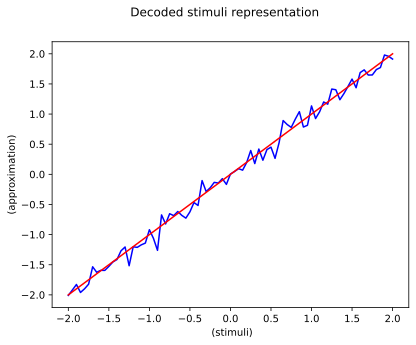

In [4]:
A = np.transpose(rates)
stddev_noise = 0.1*200
gamma_noisy = np.dot(np.transpose(A),A)/S + np.power(stddev_noise,2)*np.identity(A.shape[1])
upsilon = np.dot(np.transpose(A),x)/S
decoders = np.dot(np.linalg.inv(gamma_noisy),upsilon)

gauss_noise = np.random.normal(scale=stddev_noise,size=np.shape(A))
x_approx = np.dot(A + gauss_noise,decoders)
plt.figure()
plt.suptitle('Decoded stimuli representation')
plt.plot(x,x_approx,'b')
plt.plot(x,x,'r')
plt.xlabel(' (stimuli)')
plt.ylabel(r'(approximation)')
plt.show()

# 2. Decoding from two spiking neurons

**a) Synaptic filter.** Plot the post-synaptic current
		$$
			h(t)= \begin{cases}
				0 & \text{if } t < 0 \,, \\
				\frac{e^{-t/\tau}}{\int_0^\infty e^{-t'/\tau} \mathrm{d}t'} & \text{otherwise} \,.
			\end{cases}
		$$

/var/folders/vx/4n9y5hq95dj5b30w8b75ms1h0000gn/T/ipykernel_9837/1822401201.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(index[0])


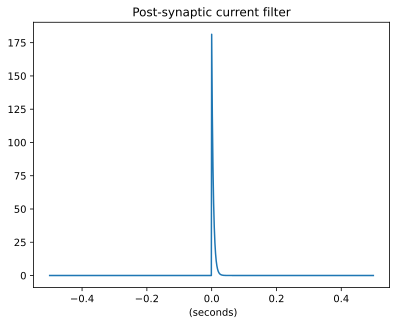

In [5]:
# Find neuron at x = 0 witih 20-50 Hz
zero_index = np.where(x == 0)[0][0]
lt_fifty = np.where(A[zero_index] <= 50)[0]
gt_twenty = np.where(A[zero_index,lt_fifty] >= 20)[0][0]
assert gt_twenty >= 0

neuron = neurons[lt_fifty[gt_twenty]]
alpha = neuron.alpha
j_bias = neuron.j_bias

pair = [LIFNeuron(), LIFNeuron()]
pair[0].set_vars(enc=-1,alpha=alpha,j_bias=j_bias)
pair[1].set_vars(enc=1,alpha=alpha,j_bias=j_bias)

T, rms, dt, limit = 1, 1, 0.001, 5
t = np.arange(0,T,dt)
sig, X = generate_signal(T=T,rms=rms,dt=dt,limit=limit, seed=seed)
spikes = []

for n in pair:
    v, num, s = n.spikes(sig,dt)
    spikes.append(s)

tau = 0.005
t_h = np.arange(1000)*dt -0.5
h = (1/tau)* np.exp(-t_h/tau)
h[np.where(t_h<0)]=0
h = (h/np.linalg.norm(h,1)) /dt


plt.title('Post-synaptic current filter')
plt.xlabel(' (seconds)')
plt.ylabel('')
plt.plot(t_h,h)
plt.show()
     

**b) Decoding using a synaptic filter.** Plot the original signal $x(t)$, the spikes, and the decoded $\hat{x}(t)$ all on the same graph.

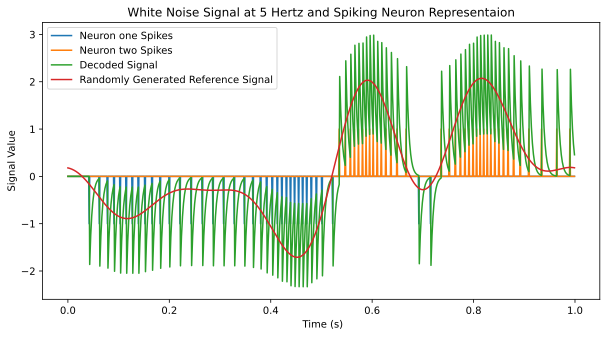

In [6]:
plt.figure(figsize=(10,5))
plt.title('White Noise Signal at %d Hertz and Spiking Neuron Representaion' % limit)
plt.xlabel(' Time (s)')
plt.ylabel('Signal Value')
neg_spikes = [-1*spike for spike in spikes[0]]
pos_spikes = spikes[1]
plt.plot(t,neg_spikes,label='Neuron one Spikes')
plt.plot(t,pos_spikes,label='Neuron two Spikes')

# Get rate decoders for neurons
rates = []
for n in pair:
    rates.append(n.rates(sig))

As = np.transpose(rates)
stddev_noise = 0.1*200
gamma_noisy = np.dot(np.transpose(As),As)/S + np.power(stddev_noise,2)*np.identity(As.shape[1])
upsilon = np.dot(np.transpose(As),sig)/S
decoders = np.dot(np.linalg.inv(gamma_noisy),upsilon)

fspikes1 = np.convolve(spikes[0], h, mode='same')
fspikes2 = np.convolve(spikes[1], h, mode='same')

As = np.array([fspikes1, fspikes2]).T
xhat = np.dot(As,decoders)
plt.plot(t,xhat, label='Decoded Signal')
plt.plot(t,sig,label='Randomly Generated Reference Signal')
plt.legend()
plt.show()
     

**c) Error analysis.** Compute the RMSE of the decoding.

In [7]:
rmse = calc_rmse(sig,xhat)

print("--------------------------------------------")
print("RMSE of the LIF Neuron = ", str(rmse))
print("-----------------------------------")


--------------------------------------------
RMSE of the LIF Neuron =  0.6446844210212777
-----------------------------------


# 3. Decoding from many neurons

**a) Exploring the error for an increasing neuron count.** Plot the Root Mean-Squared Error as the number of neurons increases, on a log-log plot. Try $8$ neurons, $16$ neurons, $32$, $64$, $128$, up to $256$. For the RMSE for a particular number of neurons, average over at least $5$ randomly generated groups of neurons. For each group of neurons, randomly generate the signal $x(t)$. Use the same parameters as in question 2.

/var/folders/vx/4n9y5hq95dj5b30w8b75ms1h0000gn/T/ipykernel_9837/1822401201.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(index[0])


0.5036050743482923
0.3495234238045157
0.270783705143054
0.2057490217556083
0.15006112286106815
0.13197828783357463


Text(0.5, 0, 'Number of Neurons')

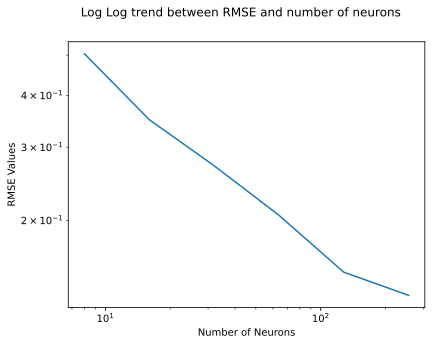

In [19]:
def generate_LIF_neurons(num):
    neurons = []
    for i in range(num):
        n = LIFNeuron()
        neurons.append(n)
    return neurons

num_runs = 5
num_neurons = [8,16,32,64,128,256]
T, rms, dt, limit = 1, 1, 0.001, 5
rmse_vals = []

for n in num_neurons:
    neurons = generate_LIF_neurons(n)
    rmse_avg = 0
    for run in range(num_runs):
        x, X = generate_signal(T=T,rms=rms,dt=dt,limit=limit, seed=seed)
        
        # Get rate decoders for neurons
        rates = []
        spikes = []
        for neuron in neurons:
            rates.append(neuron.rates(x))
            v, num, s = neuron.spikes(x,dt)
            spikes.append(s)

        rates = np.transpose(rates)
        stddev_noise = 0.1*200
        gam = np.dot(np.transpose(rates),rates)/S + np.power(stddev_noise,2)*np.identity(rates.shape[1])
        ups = np.dot(np.transpose(rates),x)/S
        d = np.dot(np.linalg.inv(gam),ups)
        
        fspikes = [np.convolve(spike, h, mode='same') for spike in spikes]
        A = np.array(fspikes).T
        xhat = np.dot(A,d)

        rmse_avg += calc_rmse(x,xhat)
    rmse_vals.append(rmse_avg/num_runs)

for val in rmse_vals:
    #print("RMSE Value for:" + str(num_neurons[val]))
    print(val)

n = [1 / N for N in num_neurons]
plt.suptitle("Log Log trend between RMSE and number of neurons")
plt.loglog(num_neurons, rmse_vals, label="Average RMSE Values of the neurons")
plt.ylabel("RMSE Values")
plt.xlabel("Number of Neurons")
# plt.ylim(0,1)
#plt.loglog(num_neurons, n, linestyle="dashed")

**b) Discussion.** Discuss your results. What is the systematic relationship between the neuron count and the error?

✍ \<YOUR SOLUTION HERE\>

# 4. Connecting two groups of neurons

**a) Computing a function.** Show the behaviour of the system with an input of $x(t)=t-1$ for $1\,\mathrm{s}$ (a linear ramp from $-1$ to $0$). Plot the ideal $x(t)$ and $y(t)$ values, along with $\hat{y}(t)$.

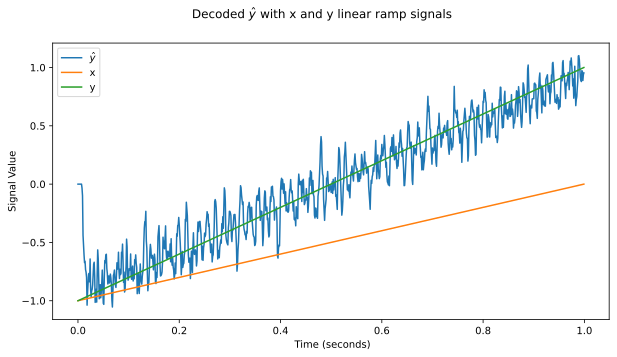

In [9]:
def generate_LIF_neuronsR1(num):
    neurons = []
    for i in range(num):
        n = LIFNeuronR1()
        neurons.append(n)
    return neurons

num_neurons = 200
t = np.arange(0,T,dt)
stddev_noise = 0.1*200

pop_one = generate_LIF_neurons(200)
pop_two = generate_LIF_neurons(200)

signal_one = np.linspace(-1,1,len(t))
signal_two = [2*k+1 for k in signal_one]
    
# Get rate decoders for neuron population one
rates_one = []
for neuron in pop_one:
    rates_one.append(neuron.rates(signal_one))
    
r_one = np.transpose(rates_one)
gam = np.dot(np.transpose(r_one),r_one)/S + np.power(stddev_noise,2)*np.identity(r_one.shape[1])
ups = np.dot(np.transpose(r_one),signal_two)/S
d_one = np.dot(np.linalg.inv(gam),ups)

# Get rate decoders for neuron population two
rates_two = []
for neuron in pop_two:
    rates_two.append(neuron.rates(signal_one))

r_two = np.transpose(rates_two)
gam = np.dot(np.transpose(r_two),r_two)/S + np.power(stddev_noise,2)*np.identity(r_two.shape[1])
ups = np.dot(np.transpose(r_two),signal_one)/S
d_two = np.dot(np.linalg.inv(gam),ups)

# Show behaviour of system
x = np.linspace(-1,0,len(t))
y = [2*k+1 for k in x]

spikes_one = []
for neuron in pop_one:
    v, num, s = neuron.spikes(x,dt)
    spikes_one.append(s)

fspikes_one = [np.convolve(s, h, mode='same') for s in spikes_one]
A = np.array(fspikes_one).T
xhat = np.dot(A,d_one)

spikes_two = []
for neuron in pop_two:
    v, num, s = neuron.spikes(xhat,dt)
    spikes_two.append(s)

fspikes_two = [np.convolve(s, h, mode='same') for s in spikes_two]
A = np.array(fspikes_two).T
yhat = np.dot(A,d_two)

plt.figure(figsize=(10,5))
plt.suptitle("Decoded $\hat y$ with x and y linear ramp signals")
plt.plot(t,yhat,label='$\hat y$')
plt.plot(t,x,label='x')
plt.plot(t,y,label='y')
#plt.plot(t,xhat)
plt.xlabel(' Time (seconds)')
plt.ylabel('Signal Value')
plt.legend()


**b) Step input.** Repeat part (a) with an input that is ten randomly chosen values between -1 and 0, each one held for 0.1 seconds (a randomly varying step input)

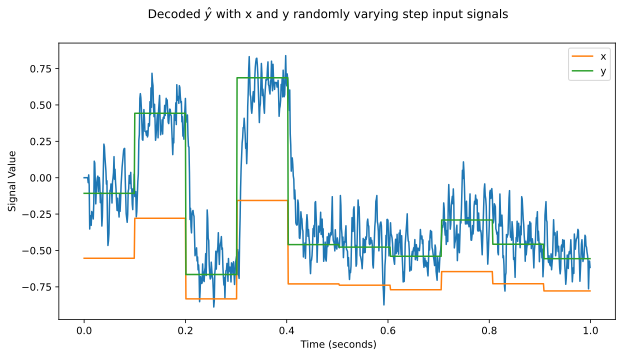

In [17]:
x = []
num = np.random.uniform(-1,0)
count = 0
for time in t:
    if count >= 100:
        num = np.random.uniform(-1,0)
        count = 0
    else:
        count += 1
    x.append(num)

y = [2*k+1 for k in x]

spikes_one = []
for neuron in pop_one:
    v, num, s = neuron.spikes(x,dt)
    spikes_one.append(s)

fspikes_one = [np.convolve(s, h, mode='same') for s in spikes_one]
A = np.array(fspikes_one).T
xhat = np.dot(A,d_one)

spikes_two = []
for neuron in pop_two:
    v, num, s = neuron.spikes(xhat,dt)
    spikes_two.append(s)

fspikes_two = [np.convolve(s, h, mode='same') for s in spikes_two]
A = np.array(fspikes_two).T
yhat = np.dot(A,d_two)

plt.figure(figsize=(10,5))
plt.suptitle("Decoded $\hat y$ with x and y randomly varying step input signals")
plt.plot(t,yhat,label='')
plt.plot(t,x,label='x')
plt.plot(t,y,label='y')
plt.xlabel(' Time (seconds)')
plt.ylabel('Signal Value')
plt.legend()

     

**c) Sinusoidal input.** Repeat part (a) with an input that is $x(t)=0.2\sin(6\pi t)$.

In [11]:
# ✍ <YOUR SOLUTION HERE>

**d) Discussion.** Briefly discuss the results for this question. Does the output match the ideal output? What kind of deviations do you see and why do those exist?

✍ \<YOUR SOLUTION HERE\>

# 5. Connecting three groups of neurons

**a) Sinusoidal input.** Plot $x(t)$, $y(t)$, the ideal $z(t)$, and the decoded $\hat{z}(t)$ for an input of $x(t)=\cos(3\pi t)$ and $y(t)=0.5 \sin (2 \pi t)$ (over $1\,\mathrm{s}$).

In [12]:
# ✍ <YOUR SOLUTION HERE>

**b) Random input.** Plot $x(t)$, $y(t)$, the ideal $z(t)$, and the decoded $\hat{z}(t)$ for a random input over $1\,\mathrm{s}$. For $x(t)$ use a random signal with a limit of $8\,\mathrm{Hz}$ and $\mathtt{rms}=1$. For $y(t)$ use a random signal with a limit of $5\,\mathrm{Hz}$ and $\mathtt{rms}=0.5$.

In [13]:
# ✍ <YOUR SOLUTION HERE>

# 6. Computing with vectors

**a) Constant inputs.** Plot the decoded output $\hat{w}(t)$ and the ideal $w$ for
		$$x =(0.5,1), \quad y = (0.1,0.3), \quad z =(0.2,0.1), \quad q = (0.4,-0.2) \,.$$

In [14]:
# ✍ <YOUR SOLUTION HERE>

**b) Sinusoidal input.** Produce the same plot for
$$x =(0.5,1), \quad y = (\sin(4\pi t),0.3), \quad z =(0.2,0.1), \quad q = (\sin(4\pi t),-0.2) \,.$$

In [15]:
# ✍ <YOUR SOLUTION HERE>

**c) Discussion.** Describe your results and discuss why and how they stray from the expected answer.

✍ \<YOUR SOLUTION HERE\>